# ML Engineer Take-home Project

## Getting started (Please make a copy and submit the completed project via the submission link in the email)
To start, copy this read-only project into a new notebook.

Make sure that you connect to a GPU instance to make training faster:
- Next to the `Connect` button on the top right, click the arrow and then `Change runtime type`.
- Select `T4 GPU`.
- Click `Connect`.

## The project
The goal of this project is to analyze the performance of a classifier, identify gaps and iterate on the model training based on those gaps.
The model is trained on a text dataset to distinguish between short sentences about science and technology and other topics.

The code provided trains a model
on the [`ag_news` dataset](https://huggingface.co/datasets/ag_news) from Hugging Face. To simplify, we transform that dataset into a binary
classification problem where the positive class corresponds to titles about Science and Technology, and all remaining topics are bundled in the negative class.

You can follow the notebook to first train a model and then evaluate it on a single input prompt.

### What is expected from the project
In addition to your experimental code, we would like to see a TLDR of the project that summarizes the assumptions you made, why you decided to tackle it the way you did, and what you would do in follow up steps. We would also like to see a summary of your findings in your own words.

**In summary, you should upload a Jupyter notebook with the following**:
- All the code your ran with populated outputs.
- At the top of the notebook, a markdown cell with the TLDR of your project.

In order to make sure that the outputs are saved, go to Edit > Notebook Settings and make sure that the box 'Omit code cell output when saving this notebook' is **unchecked**.

### Goal
You are part of a team that wants to expand this initial model into a production-ready model. This model should be able to classify any short string into Science/Technology vs other topics, regardless of its source. The model trained on this dataset is the initial iteration, but you are aware that there are many blindspots and that the work has just begun: we are far from production-ready.

Your main goal is simple: get an understanding of what is wrong with the model and improve it. You are free to clarify on which dimensions you want to focus your analysis and to define what production-ready means.

We are particularly interested in how you approach the problem. Ideally, we would like to see:
- That you start by writing explicit tests and identifying where the model falls short.
- That you prioritize onboarding the data that needs to be collected next and find creative ways to get it.
- How you measure the model's robustness and write training time augmentations to make the model more robust (there is an `augment_dataset` placeholder).

We provide an OpenAI key for this project which you can use to generate data if needed.

Assumptions:
- For simplicity and to reduce training time, we assume that all inputs in production will be
under 64 tokens and therefore we are truncating inputs to 64 tokens. Feel free to discuss the implications of this assumption.


**Note**:
- This exercise is open-ended, there is no unique solution or approach. We are interested in how you think about the problem, how you approach testing and prioritizing the gaps to be filled. Given the breadth of the task, we will focus on your approach and achieving a few key milestones, rather than starting a lot of different things that don't get to the finish line.
- You don't *have* to use this notebook. Feel free to download this code and work locally if you find it easier, though training times may be much longer if you don't have a GPU on your machine.


Let's install the necessary packages.

In [ ]:
#%pip install transformers>=4.40.1
#%pip install datasets>=2.19.0
#%pip install evaluate>=0.4.1
#%pip install accelerate>=0.29.3
#%pip install scikit-learn>=1.4.2
#%pip install torch>=2.3.0

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
import evaluate
import numpy as np
import pandas as pd

from datasets import load_dataset
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

Now, let's write down the functions needed to load and prepare our data, as well as train the model on a few epochs.

**Notice that there are some placeholders for you to add augmentations if needed**.

In [17]:
def augment_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """TODO: write agumentation code to make the model more robust"""

    return df


def load_and_prepare_dataset() -> DatasetDict:
    """Loads the dataset from HF and creates train/test splits."""

    # Classify science vs non-science.
    science_index = 3
    dataset = load_dataset("ag_news")

    train_df = process_dataset(dataset["train"], science_index)
    test_df = process_dataset(dataset["test"], science_index)

    return DatasetDict(
        {
            "train": Dataset.from_pandas(train_df),
            "test": Dataset.from_pandas(test_df),
        }
    ), train_df, test_df


def process_dataset(dataset: Dataset, class_index: int) -> pd.DataFrame:
    """Converts a HF dataset to Pandas and performs pre-processing."""
    df = dataset.to_pandas()
    df["label"] = df["label"].apply(lambda id: int(id == class_index))
    # Balance the dataset
    df = pd.concat(
        [
            df[df["label"] == 0].sample(frac=1.0 / 3, random_state=42),
            df[df["label"] == 1].sample(frac=1.0, random_state=42),
        ]
    )
    df_augmented = pd.read_csv("augmented_data/augmented_train.csv")

    #
    # TODO: Here, you can add augmentations
    
    df = pd.concat([df, df_augmented], ignore_index=True)
    
    #df = augment_dataset(df)
    # Shuffle and return the dataset.
    return df.sample(frac=1, random_state=42)


def train(dataset) -> None:
    """Trains a model on a HF dataset using TinyBERT."""

    # Create the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

    def preprocess_function(examples, max_length: int = 64):
        # To make training faster, we consider only short inputs of max 64 tokens.
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
        )

    # Tokenize the dataset
    tokenized_dataset = dataset.map(preprocess_function, batched=True)

    # Initialize the model
    model = AutoModelForSequenceClassification.from_pretrained(
        "prajjwal1/bert-tiny", num_labels=2
    )
    # Make sure you are running on a GPU instance to accelerate training.
    model.to("cuda")

    for param in model.parameters():
      param.data = param.data.contiguous()

    # Define the metric of choice (here, accuracy)
    accuracy = evaluate.load("accuracy")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return {
            "accuracy": accuracy.compute(predictions=predictions, references=labels),
            "precision": precision.compute(predictions=predictions, references=labels),
            "recall": recall.compute(predictions=predictions, references=labels),
        }

    # Training arguments. The checkpoints are saved in ./results after every epoch.
    training_args = TrainingArguments(
        report_to="none",  # Disable WanDB
        output_dir="./results",
        per_device_train_batch_size=128,
        per_device_eval_batch_size=128,
        evaluation_strategy="steps",
        save_strategy="steps",
        save_steps=500,
        eval_steps=1000,
        num_train_epochs=3,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

Let's load the dataset and train the model! The results with be available in the `results` directory, which you can find by clicking on the file icon on the left.

In [4]:
dataset, train_df, test_df = load_and_prepare_dataset(augment_dataset=False)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 3800
    })
})

In [6]:
train_df["label"].value_counts()

0    30000
1    30000
Name: label, dtype: int64

In [7]:
train(dataset)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3800 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## My Results

### Evaluation of the Baseline Model

- The misclassifications in your model's results suggest a few areas where it may be falling short in distinguishing between science/technology and other types of news.

              precision    recall  f1-score   support

 Non-Science       0.95      0.91      0.93      1900
     Science       0.91      0.96      0.93      1900

    accuracy                           0.93      3800
   macro avg       0.93      0.93      0.93      3800
weighted avg       0.93      0.93      0.93      3800



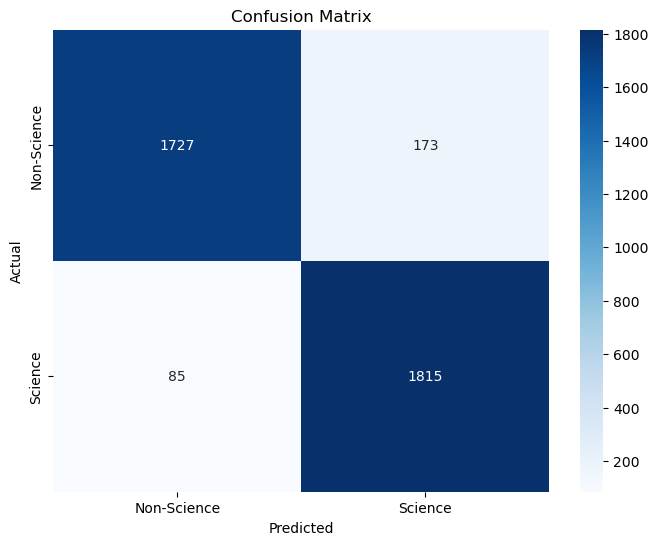

Misclassified samples saved to 'data/misclassified_samples.csv'.


In [8]:
import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer  # Importing LIME


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Non-Science", "Science"], 
                yticklabels=["Non-Science", "Science"])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()


# Define a wrapper function for the model that returns probabilities (for LIME)
def predict_proba(texts, model, tokenizer):
    inputs = tokenizer(texts, truncation=True, padding=True, max_length=64, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1).numpy()  # Get probabilities for each class
    return probs


def eval():
    # Provide the path to the checkpoint directory.
    model_checkpoint = "./results/checkpoint-1000"
   
    # Load the test dataset from the DatasetDict
    #test_dataset = dataset["test"].select(range(100))
    test_dataset = dataset["test"]

    # Load the trained model
    tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint, num_labels=2
    )

    # Tokenize the test dataset
    test_encodings = tokenizer(
        test_dataset['text'],  # Access the 'text' field directly
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors="pt"
    )

    # Make predictions on the test dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**test_encodings)

    # predicted classes and prediction probabilities
    logits = outputs.logits
    predictions = np.argmax(logits.numpy(), axis=1)
    probabilities = torch.softmax(logits, dim=1).numpy()  # Convert logits to probabilities

    # Calculate metrics
    y_true = test_dataset['label']  # Convert labels to numpy array for metric calculations

    print(classification_report(y_true, predictions, target_names=["Non-Science", "Science"]))
    plot_confusion_matrix(y_true, predictions)

    # Identify misclassified samples
    incorrect_indices = np.where(predictions != y_true)[0]  # Indices where predictions are wrong

    # Prepare data for the CSV file, including probability of predicted class
    misclassified_data = {
        "Text": [test_dataset['text'][idx] for idx in incorrect_indices],
        "True Label": [y_true[idx] for idx in incorrect_indices],
        "Predicted Label": [predictions[idx] for idx in incorrect_indices],
        "Probability of Predicted Class": [probabilities[idx][predictions[idx]] for idx in incorrect_indices],  # Probability of the predicted class
    }

    # Save to CSV using pandas
    df_misclassified = pd.DataFrame(misclassified_data)
    df_misclassified.to_csv("eval/misclassified_samples.csv", index=False)

    print(f"Misclassified samples saved to 'data/misclassified_samples.csv'.")

    '''
    # Initialize LIME explainer
    explainer = LimeTextExplainer(class_names=["Non-Science", "Science"])

    # Provide explanations for misclassified samples
    for idx in incorrect_indices[:5]:  # Limit to 5 explanations for demonstration purposes
        text_to_explain = test_dataset['text'][idx]
        true_label = y_true[idx]
        predicted_label = predictions[idx]

        # Explain the prediction using LIME
        exp = explainer.explain_instance(text_to_explain, 
                                         lambda x: predict_proba(x, model, tokenizer), 
                                         num_features=10)

        print(f"\nText: {text_to_explain}")
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
        exp.show_in_notebook(text=True)  # Show explanation in a Jupyter notebook (optional)
        exp.save_to_file(f"eval/lime_explanation_{idx}.html")  # Save to an HTML file for later review
    '''

    '''
     # Provide the input text you wish to evaluate.
    text = "Card fraud unit nets 36,000 cards In its first two years, the UK's dedicated card fraud unit, has recovered 36,000 stolen cards and 171 arrests - and estimates it saved 65m."

    inputs = tokenizer(text, return_tensors="pt")
    # Make a prediction
    with torch.no_grad():
        outputs = model(**inputs)

    print(f"Predicted class: {outputs.logits[0].numpy().argmax()}")
    '''
    

eval()

### Data Generation Process

- The llama3_data_gen.py script enables data generation using a few-shot learning approach by selecting random samples from misclassified instances. It then generates new labeled samples utilizing the LLaMA 3 70B model.
- This process effectively augments the initial dataset, providing additional training data.
- We subsequently retrain the model using this augmented dataset to enhance its performance and accuracy.

### Validation Data
- The results achieved with the augmented data from the LLM are lower than those reported in the initial evaluation (which exceeded 90% accuracy).
- We will create an augmented dataset using misclassified samples and subsequently retrain our model with this new data.
- After retraining, we will assess the changes in performance.

In [9]:
validation_df = pd.read_csv("augmented_data/augmented_validation.csv")
validation_df.head()

,text,label
0,NASA's Perseverance rover has discovered evide...,1
1,Apple's new iPhone 14 is expected to feature a...,0
2,A new study published in the journal Nature re...,1
3,Facebook's latest algorithm update has sparked...,0
4,Scientists have discovered a new species of an...,1


In [10]:
validation = Dataset.from_pandas(validation_df)
validation

Dataset({
    features: ['text', 'label'],
    num_rows: 200
})

In [54]:
def eval():
    # Provide the path to the checkpoint directory.
    model_checkpoint = "./baseline_results/checkpoint-1000"
   
    # Load the test dataset from the DatasetDict
    #test_dataset = dataset["test"].select(range(100))
    test_dataset = validation

    # Load the trained model
    tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint, num_labels=2
    )

    # Tokenize the test dataset
    test_encodings = tokenizer(
        test_dataset['text'],  # Access the 'text' field directly
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors="pt"
    )

    # Make predictions on the test dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**test_encodings)

    # predicted classes and prediction probabilities
    logits = outputs.logits
    predictions = np.argmax(logits.numpy(), axis=1)
    probabilities = torch.softmax(logits, dim=1).numpy()  # Convert logits to probabilities

    # Calculate metrics
    y_true = test_dataset['label']  # Convert labels to numpy array for metric calculations

    print(classification_report(y_true, predictions, target_names=["Non-Science", "Science"]))
    plot_confusion_matrix(y_true, predictions)

              precision    recall  f1-score   support

 Non-Science       0.95      0.19      0.31       102
     Science       0.54      0.99      0.70        98

    accuracy                           0.58       200
   macro avg       0.74      0.59      0.50       200
weighted avg       0.75      0.58      0.50       200



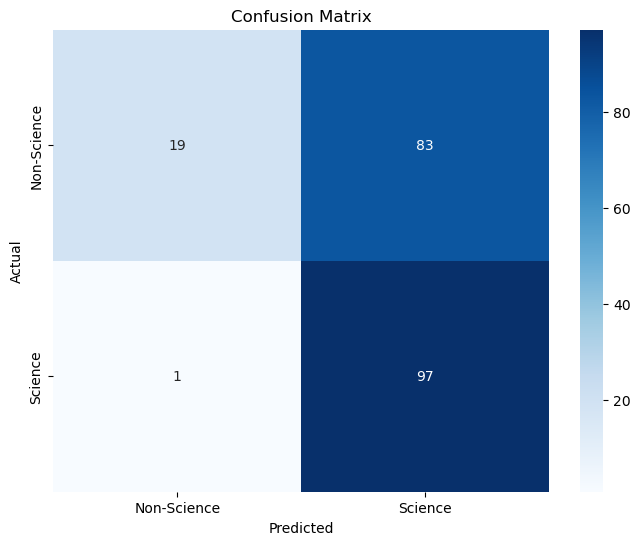

In [55]:
eval()

### Augment Training dataset using LLM + Retrain Model

In [18]:
dataset, train_df, test_df = load_and_prepare_dataset()

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 61943
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 5743
    })
})

In [20]:
train(dataset)

Map:   0%|          | 0/61943 [00:00<?, ? examples/s]

Map:   0%|          | 0/5743 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

 Non-Science       0.66      0.32      0.43       102
     Science       0.54      0.83      0.65        98

    accuracy                           0.57       200
   macro avg       0.60      0.58      0.54       200
weighted avg       0.60      0.57      0.54       200



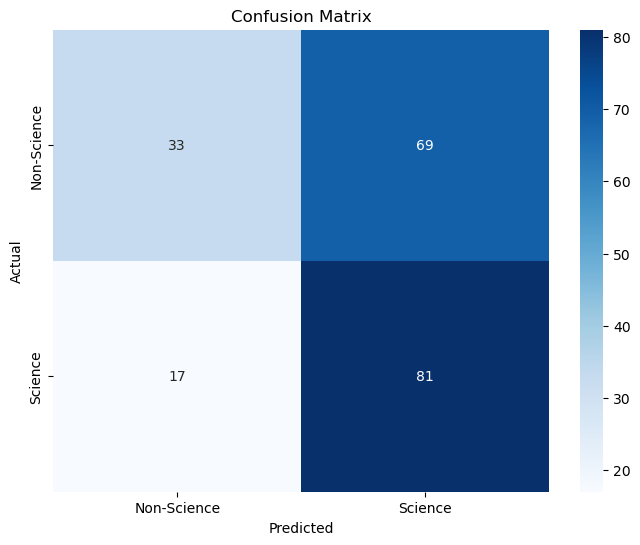

In [21]:
def eval():
    # Provide the path to the checkpoint directory.
    model_checkpoint = "./results/checkpoint-1000"
   
    # Load the test dataset from the DatasetDict
    #test_dataset = dataset["test"].select(range(100))
    test_dataset = validation

    # Load the trained model
    tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint, num_labels=2
    )

    # Tokenize the test dataset
    test_encodings = tokenizer(
        test_dataset['text'],  # Access the 'text' field directly
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors="pt"
    )

    # Make predictions on the test dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**test_encodings)

    # predicted classes and prediction probabilities
    logits = outputs.logits
    predictions = np.argmax(logits.numpy(), axis=1)
    probabilities = torch.softmax(logits, dim=1).numpy()  # Convert logits to probabilities

    # Calculate metrics
    y_true = test_dataset['label']  # Convert labels to numpy array for metric calculations

    print(classification_report(y_true, predictions, target_names=["Non-Science", "Science"]))
    plot_confusion_matrix(y_true, predictions)


eval()

### Conclusion
- An analysis of roughly 1,000 samples generated from the LLM indicates a slight improvement.
- We can achieve better results by expanding the dataset, which will enhance overall efficiency.
- Moreover, investigating different models, like RoBERTa, may provide superior performance compared to the original BERT model.
- Although the current model is not yet suitable for production, this approach should be further developed with additional samples to enhance generalization. Additionally, the initial transformer model can be scaled up for better results.





